In [36]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN

from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw

from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle

# Data Preperation

In [37]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids

## Training Data

In [38]:
training_dataset_annotation_path = '../datasets/Betel Diseases/labels/betel_leaf_disease_labels_coco.json'
training_dataset_path = '../datasets/Betel Diseases'

In [39]:
dataset_train = CocoLikeDataset()
dataset_train.load_data(training_dataset_annotation_path, training_dataset_path)
dataset_train.prepare()

## Testing Data

In [40]:
dataset_val = CocoLikeDataset()
# this details need to be set using validation data, currently use training data for testing
dataset_val.load_data(training_dataset_annotation_path, training_dataset_path)
dataset_val.prepare()

#### Preview Random 3 Images

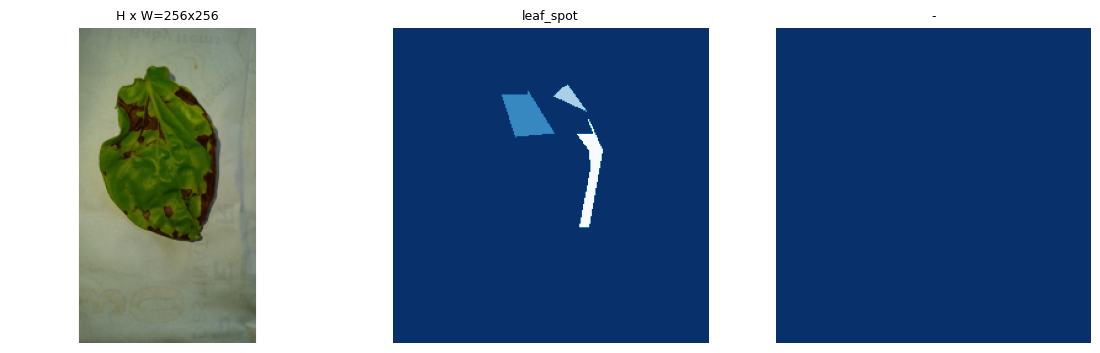

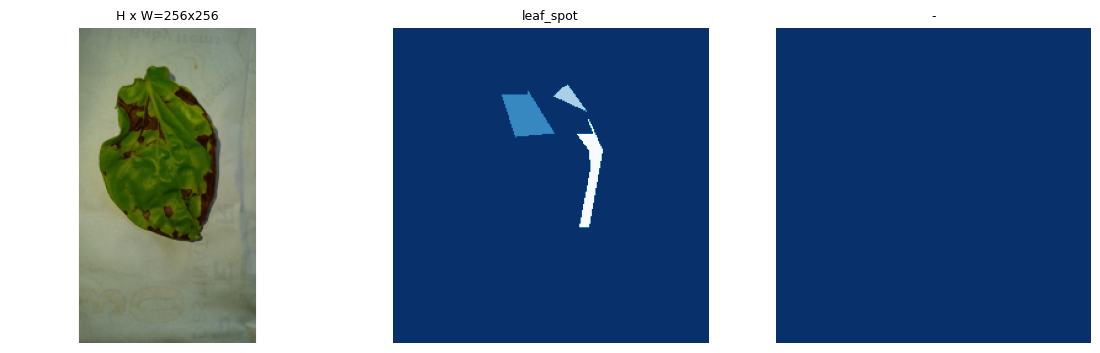

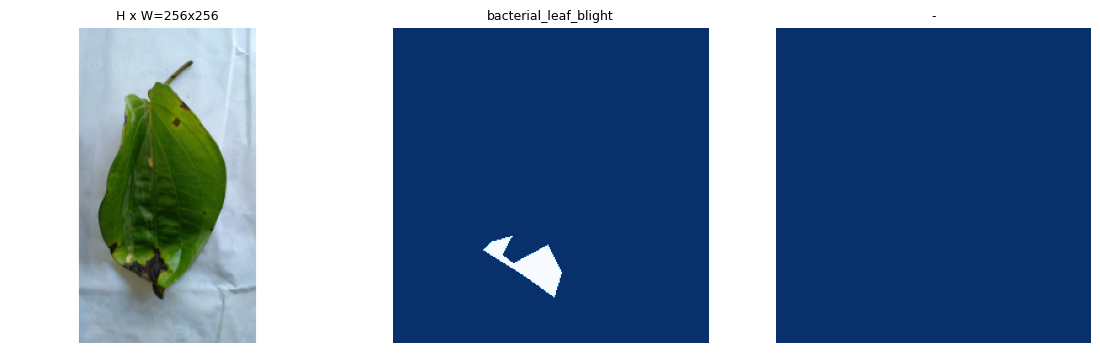

In [41]:
image_ids = np.random.choice(dataset_train.image_ids, 3)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    display_top_masks(
        image,
        mask,
        class_ids,
        dataset_train.class_names,
        limit=2
    )  # limit to total number of classes

#### Print Image with Mask and Class Name

In [42]:
# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

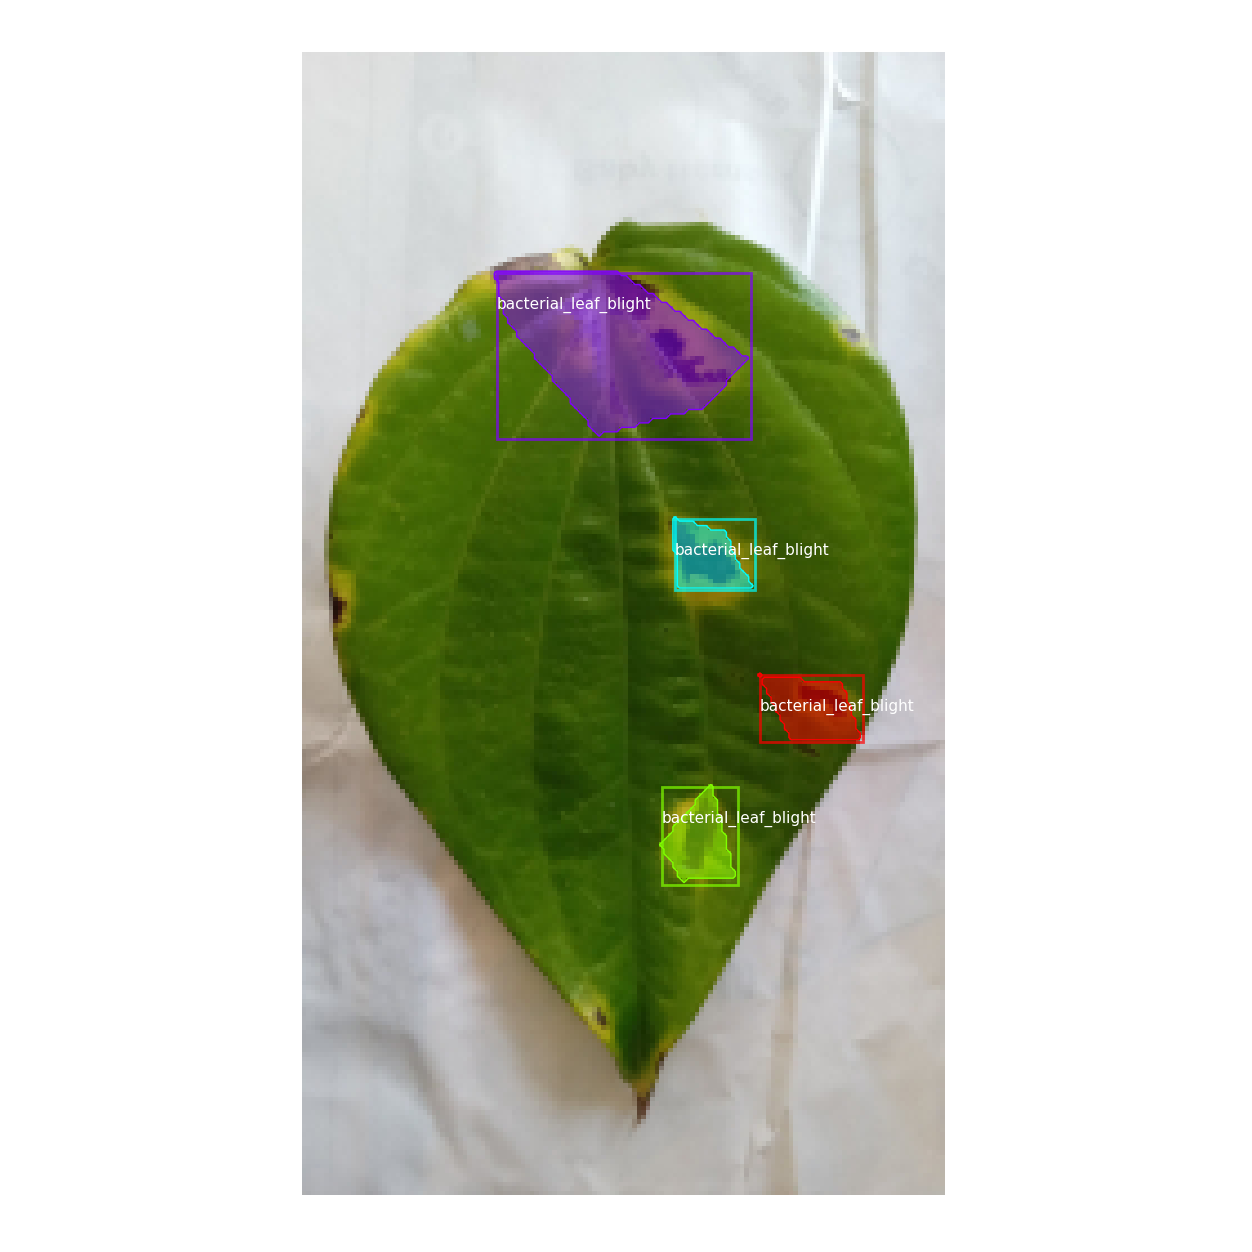

In [43]:
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

## Model Configurations

**Important**: need to change the number of classes based on your dataset

In [44]:
class ModelConfig(Config):
    # define the name of the configuration
    # NAME = "mrcnn_config_coco"
    ## ! TODO
    NAME = "betel_diseases_coco"
    # number of classes (background + class 1 + class 2)
    NUM_CLASSES = 1 + 3
    # number of training steps per epoch !TEST THIS
    STEPS_PER_EPOCH = 1
    USE_MINI_MASK = False
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8 # Skip detections with < 80% confidence

#### Current Model Configs

In [45]:
# prepare config
config = ModelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Directories

In [46]:
ROOT_DIR = os.path.abspath("./")
print(f'Root Dir: {ROOT_DIR}')

# import Mask RCNN module to path
sys.path.append(ROOT_DIR)  # To find local version of the library

# log path: directory to save logs and trained models
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

Root Dir: C:\Users\ACER\Documents\My mini Projects\ML\Betel Leaves\disease_detection


## Model Defining

In [47]:
model = MaskRCNN(
    mode='training',
    model_dir=DEFAULT_LOGS_DIR,
    config=config
)

In [48]:
# load weights (mscoco) and exclude the output layers
model.load_weights(
    COCO_WEIGHTS_PATH,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)


## Model Training

In [49]:
# train weights (output layers or 'heads')
model.train(
    dataset_train,
    dataset_train,
    learning_rate=config.LEARNING_RATE,
    epochs=1,
    layers='heads'
)


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\ACER\Documents\My mini Projects\ML\Betel Leaves\disease_detection\logs\betel_diseases_coco\mask_rcnn_betel_diseases_coco.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribute

C:\Users\ACER\Documents\My mini Projects\ML\Betel Leaves\venv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Model Evaluation

In [50]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

## Model - Inference

In [51]:
model = MaskRCNN(
    mode='inference',
    model_dir='logs',
    config=config
)


In [52]:
trained_model_path = os.path.join('logs', f'{config.NAME}\mask_rcnn_{config.NAME}.h5')
print(f'Trained model path: {trained_model_path}')
# load model weights
model.load_weights(
    trained_model_path,
    by_name=True
)

Trained model path: logs\betel_diseases_coco\mask_rcnn_betel_diseases_coco.h5


### Evaluationg Trained Model
> This method computes the **mean Average Precision** (mAP) for a given object detection model.
- mAP is a commonly used evaluation metric for object detection models, which takes into account both precision and recall across all object classes in a dataset.
- The method takes as input the predicted object detections and their corresponding ground truth annotations, and returns the mAP value as a float between 0 and 1.
- The higher the mAP value, the better the performance of the object detection model.


In [53]:
train_mAP = evaluate_model(
    dataset_train,
    model,
    config
)
print("Train mAP: %.3f" % train_mAP)

Train mAP: 0.000


## Testing: Real World Sample

In [54]:
print(dataset_train.class_names)

['BG', 'bacterial_leaf_blight', 'leaf_spot', 'stem_disease']


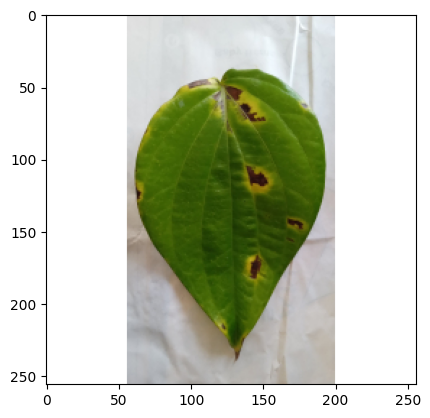

In [55]:
sample_img_path = '../datasets/Betel Diseases/20230409_170752114.jpg'
sample_img = skimage.io.imread(sample_img_path)
plt.imshow(sample_img)

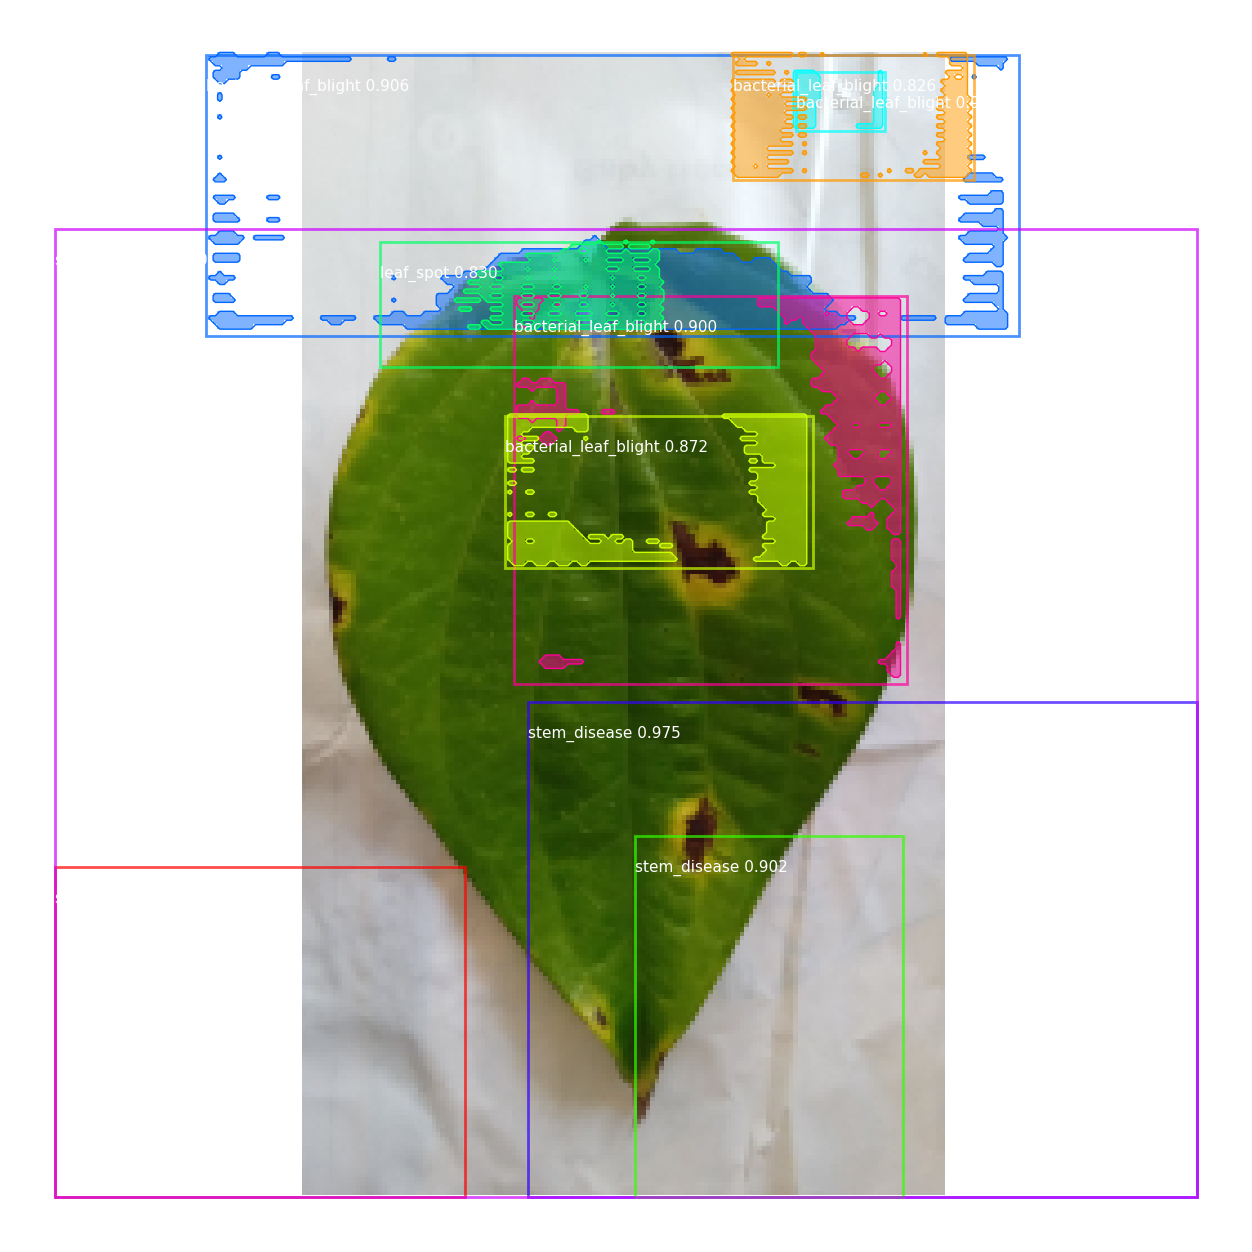

In [56]:

detected = model.detect([sample_img])
results = detected[0]
class_names = dataset_train.class_names
display_instances(
    sample_img,
    results['rois'],
    results['masks'],
    results['class_ids'],
    class_names,
    results['scores']
)

In [57]:
predicted_class_ids= detected[0]['class_ids']
pred_to_text = [class_names[class_id] for class_id in predicted_class_ids]
print(pred_to_text)

['stem_disease', 'bacterial_leaf_blight', 'stem_disease', 'bacterial_leaf_blight', 'stem_disease', 'bacterial_leaf_blight', 'bacterial_leaf_blight', 'stem_disease', 'leaf_spot', 'bacterial_leaf_blight']


In [58]:
# Show detected objects in color and all others in B&W
def color_splash(img, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(img)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, img, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash

In [59]:
def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        # print("Running on {}".format(img))
        # Read image
        img = skimage.io.imread(image_path)
        # Detect objects
        r = model.detect([img], verbose=1)[0]
        # Color splash
        splash = color_splash(img, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, img = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                img = img[..., ::-1]
                # Detect objects
                r = model.detect([img], verbose=0)[0]
                # Color splash
                splash = color_splash(img, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

In [60]:
detect_and_color_splash(
    model,
    image_path=sample_img_path)



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Saved to  splash_20230512T220336.png
